# Adım 1: İhtiyaç Noktaları ve Depo Koordinatları ile Mesafe Hesaplama

In [ ]:
import pandas as pd
import numpy as np
import itertools
from scipy.spatial.distance import cdist

# İhtiyaç noktası ve depo sayısı
num_needs = 45 ## İhtiyaç Noktası
num_depots = 3 ## Depo Adeti

# İhtiyaç noktası ve depo koordinatları
np.random.seed(0)
need_points = np.random.rand(num_needs, 2) * 100  # 100x100 koordinat aralığında
depot_points = np.array([[0, 0], [100, 0], [50, 100]])  # Kuzey, Güney, Doğu depo noktaları

# Tüm noktalar (depolar + ihtiyaç noktaları)
all_points = np.vstack([depot_points, need_points])

# Mesafe Matrisi Oluşturma
dist_matrix = cdist(all_points, all_points, metric='euclidean')

# DataFrame olarak kaydetme
dist_df = pd.DataFrame(dist_matrix, columns=[f'P{i}' for i in range(len(all_points))],index=[f'P{i}' for i in range(len(all_points))])
dist_df.to_excel('ihtiyac_noktalari_mesafeleri.xlsx', index=True)
print("İhtiyaç Noktaları Mesafe Dosyası oluşturuldu.")

# İhtiyaç noktaları için talep oluşturma
medical_needs = np.random.randint(5, 20, size=(num_needs, num_depots))  # Tıbbi malzeme talebi
food_needs = np.random.randint(10, 30, size=(num_needs, num_depots))  # Yiyecek talebi

# Talep tablosu oluşturma
needs_data = {
    'İhtiyaç Noktasi': [f'P{i+num_depots}' for i in range(num_needs)],
    'Kuzey Depo (Tibbi)': medical_needs[:, 0],
    'Kuzey Depo (Yiyecek)': food_needs[:, 0],
    'Güney Depo (Tibbi)': medical_needs[:, 1],
    'Güney Depo (Yiyecek)': food_needs[:, 1],
    'Doğu Depo (Tibbi)': medical_needs[:, 2],
    'Doğu Depo (Yiyecek)': food_needs[:, 2],
}

needs_df = pd.DataFrame(needs_data)
needs_df.to_excel('yardim_talep_dosyasi.xlsx', index=False)

print("Yardim Talep Dosyasi oluşturuldu.")

İhtiyaç Noktaları Mesafe Dosyası oluşturuldu.
Yardim Talep Dosyasi oluşturuldu.


# Adım 2: Kümeleme(Clustering)

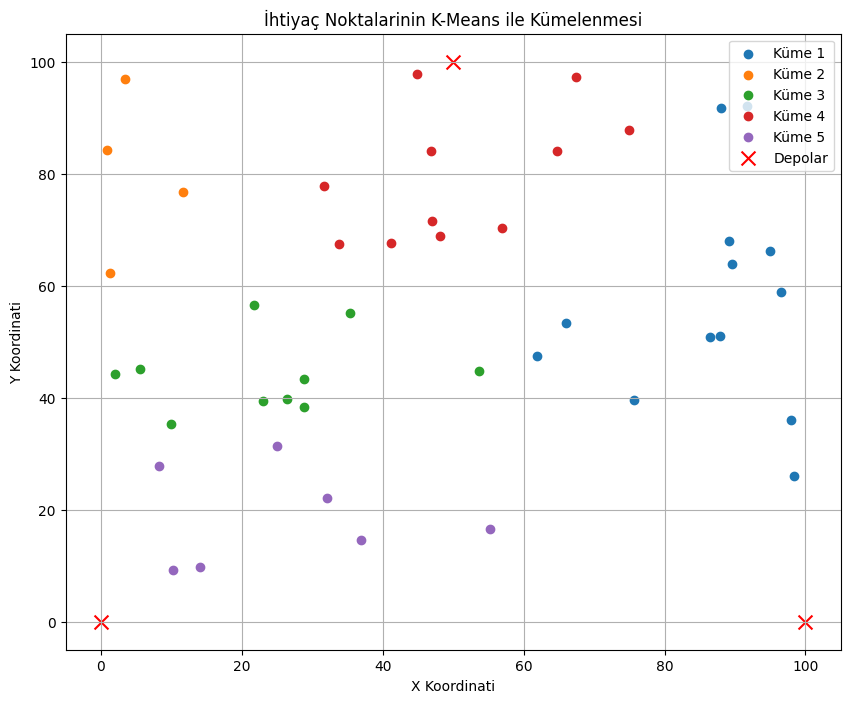

In [27]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# İhtiyaç noktaları ve depo verilerini yükleme
num_depots = 3  # Önceden tanımladığımız depo sayısı
dist_df = pd.read_excel('ihtiyac_noktalari_mesafeleri.xlsx', index_col=0)
all_points = dist_df.index[num_depots:]  # Sadece ihtiyaç noktalarını seçiyoruz

# İhtiyaç noktalarının koordinatlarını yükleme
need_points = np.random.rand(len(all_points), 2) * 100  # 100x100 aralığında konumlar

# K-means kümeleme (5 küme)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(need_points)

# Kümeleri görselleştirme
plt.figure(figsize=(10, 8))
for cluster_id in range(num_clusters):
    cluster_points = need_points[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Küme {cluster_id + 1}')

plt.scatter([0, 100, 50], [0, 0, 100], c='red', marker='x', s=100, label='Depolar')  # Depo noktalarını göster
plt.legend()
plt.title("İhtiyaç Noktalarinin K-Means ile Kümelenmesi")
plt.xlabel("X Koordinati")
plt.ylabel("Y Koordinati")
plt.grid()
plt.show()

# Adım 3: Rota Optimizasyonu


In [29]:
# Grafikte düğüm ekleme ve isimlendirme işlemlerini daha açık bir şekilde yeniden yapılandıralım
import pandas as pd
import networkx as nx
import numpy as np
from scipy.spatial.distance import cdist

# Mesafe verilerini tekrar yükleyelim ve düğümleri doğru şekilde tanımlayalım
dist_df = pd.read_excel('ihtiyac_noktalari_mesafeleri.xlsx', index_col=0)
all_points = dist_df.index.tolist()  # Tüm düğüm isimlerini (depolar ve ihtiyaç noktaları) listede topluyoruz

# Ağ grafiğini oluşturma ve düğümleri ekleme
G = nx.Graph()
for point in all_points:
    G.add_node(point)

# Kenarları ekleme - her iki düğüm arasında mesafe olduğu sürece onları bağlayalım
for i, point1 in enumerate(all_points):
    for j, point2 in enumerate(all_points):
        if i != j:
            distance = dist_df.loc[point1, point2]
            G.add_edge(point1, point2, weight=distance)

# Rota optimizasyonu - Küme için en kısa yolu bulma
start_depot = 'P0'  # Başlangıç noktası (örneğin Kuzey Depo)
cluster_points = [f'P{i}' for i in range(3, 10)]  # Örneğin ilk kümeye ait 7 noktayı seçiyoruz

# A* algoritmasıyla en kısa yolu bulma
path = []
current_point = start_depot
for target in cluster_points:
    try:
        path_segment = nx.astar_path(G, current_point, target, heuristic=lambda u, v: dist_df.loc[u, v])
        path.extend(path_segment)
        current_point = target  # Sonraki başlangıç noktası, önceki hedef noktası olur
    except nx.NetworkXNoPath:
        print(f"{current_point} ile {target} arasında yol bulunamadı.")

print("Küme için bulunan en kısa rota:", path)


Küme için bulunan en kısa rota: ['P0', 'P3', 'P3', 'P4', 'P4', 'P5', 'P5', 'P6', 'P6', 'P7', 'P7', 'P8', 'P8', 'P9']


# Adım4: Rota Görselleştirme 


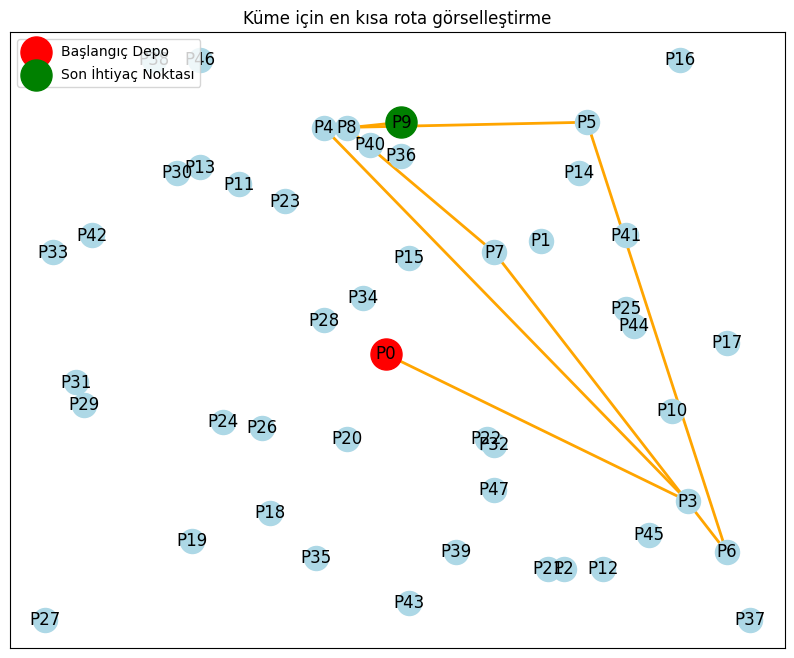

In [24]:
import matplotlib.pyplot as plt

# Düğüm koordinatlarını rastgele şekilde oluşturuyoruz (örnek olması için)
np.random.seed(0)
positions = {point: (np.random.randint(0, 100), np.random.randint(0, 100)) for point in all_points}

# Grafiği çizme işlemi
plt.figure(figsize=(10, 8))

# Tüm düğümleri ve kenarları çizelim
nx.draw_networkx_nodes(G, pos=positions, node_size=300, node_color='lightblue')
nx.draw_networkx_labels(G, pos=positions, labels={node: node for node in G.nodes()})

# Rota üzerindeki düğümleri ve yolları çizelim
for i in range(len(path) - 1):
    current_node = path[i]
    next_node = path[i + 1]
    nx.draw_networkx_edges(G, pos=positions, edgelist=[(current_node, next_node)], width=2, edge_color='orange')

# Başlangıç ve bitiş düğümlerini özellikle gösterelim
nx.draw_networkx_nodes(G, pos=positions, nodelist=[start_depot], node_size=500, node_color='red', label='Başlangıç Depo')
nx.draw_networkx_nodes(G, pos=positions, nodelist=[path[-1]], node_size=500, node_color='green', label='Son İhtiyaç Noktası')

plt.title("Küme için en kısa rota görselleştirme")
plt.legend(loc="upper left")
plt.show()